# Importanto as bibliotecas e carregando as imagens

In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
healthy =  '/home/EddyPerondini/Documentos/Projetos Pessoais/Imagens/test_healthy_124.jpeg'
cancer = '/home/EddyPerondini/Documentos/Projetos Pessoais/Imagens/test_cancer124.jpeg'

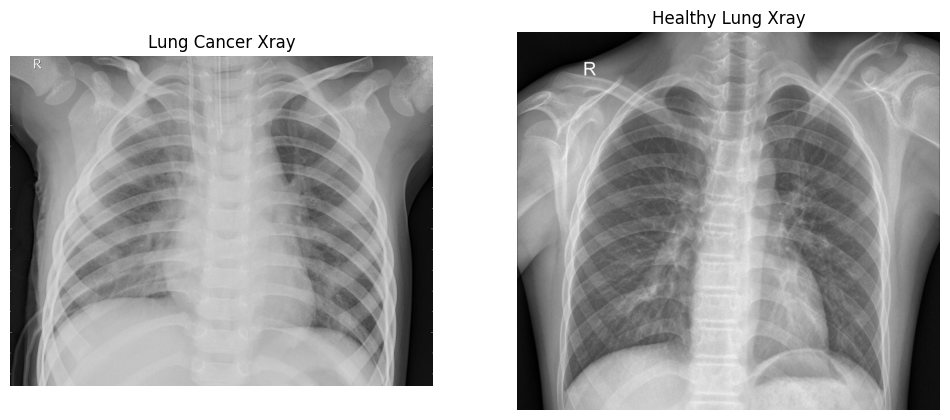

In [3]:
img_healthy = cv2.imread(healthy) 
img_cancer = cv2.imread(cancer)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_cancer)
axes[0].axis('off')
axes[0].set_title('Lung Cancer Xray')

axes[1].imshow(img_healthy)
axes[1].axis('off')
axes[1].set_title('Healthy Lung Xray')

plt.show()


# Brincando com as imagens

In [4]:
#Visualizando o shape das imagens

shape_healthy = img_healthy.shape
shape_cancer = img_cancer.shape

shape_cancer, shape_healthy

((1000, 1280, 3), (1916, 2144, 3))

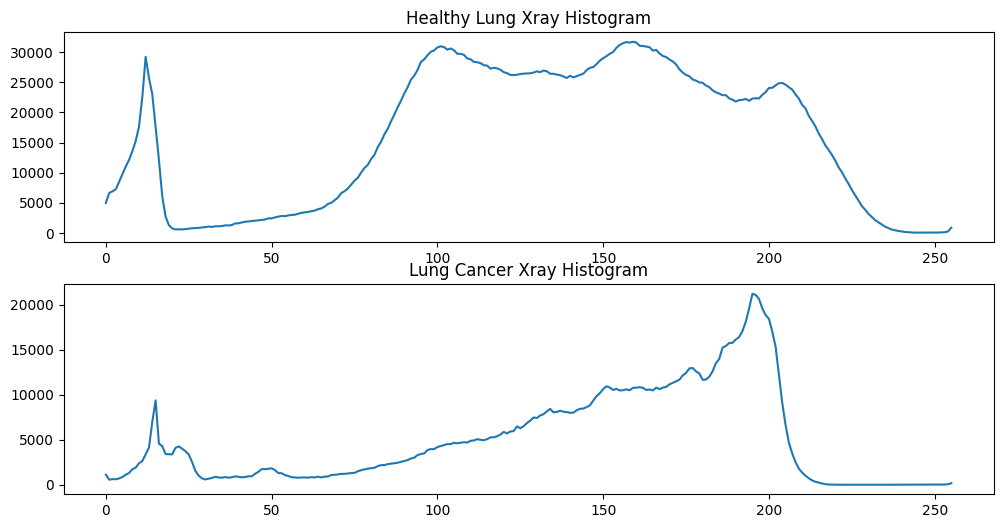

In [5]:
#Convertendo as imagens para tons de cinza --> shape_channels = 1 

img_healthy_c = cv2.cvtColor(img_healthy, cv2.COLOR_BGR2GRAY)
img_cancer_c = cv2.cvtColor(img_cancer, cv2.COLOR_BGR2GRAY)

#Gerando os histogramas de cada imagens --> avaliar presença de ruído e o perfil de distribuição dos pixels

hist_healthy = cv2.calcHist([img_healthy_c], [0], None, [256], [0,256])  
hist_cancer = cv2.calcHist([img_cancer_c],  [0], None, [256], [0,256])

#Plotando as distribuições 

fig, axes = plt.subplots(2, 1, figsize = (12,6))

axes[0].plot(hist_healthy)
axes[0].set_title('Healthy Lung Xray Histogram')

axes[1].plot(hist_cancer)
axes[1].set_title('Lung Cancer Xray Histogram')

plt.show()

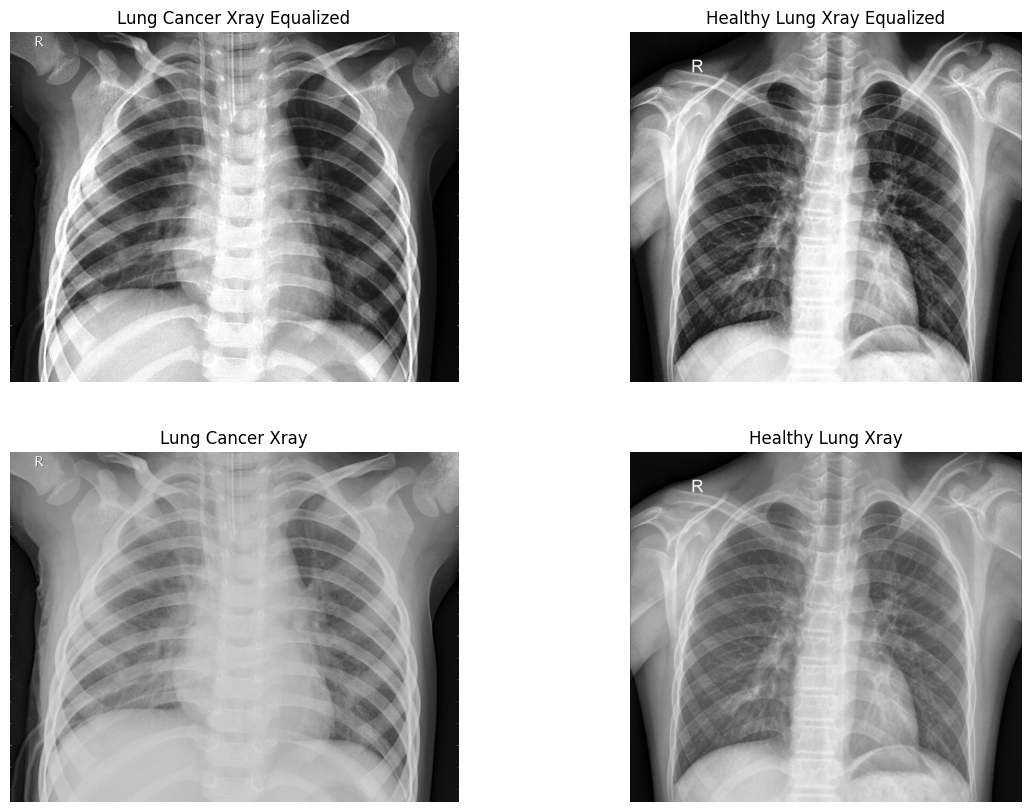

In [6]:
#Mexendo no contraste das imagens --> evidenciando pixels por meio da equalização dos histogramas 

equalized_healthy = cv2.equalizeHist(img_healthy_c)
equalized_cancer =  cv2.equalizeHist(img_cancer_c)

#Apresentando as imagens equalizadas 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].imshow(equalized_cancer, cmap = 'gray')
axes[0,0].axis('off')
axes[0,0].set_title('Lung Cancer Xray Equalized')

axes[0,1].imshow(equalized_healthy, cmap = 'gray')
axes[0,1].axis('off')
axes[0,1].set_title('Healthy Lung Xray Equalized')

axes[1,0].imshow(img_cancer)
axes[1,0].axis('off')
axes[1,0].set_title('Lung Cancer Xray')

axes[1,1].imshow(img_healthy)
axes[1,1].axis('off')
axes[1,1].set_title('Healthy Lung Xray')

plt.show()

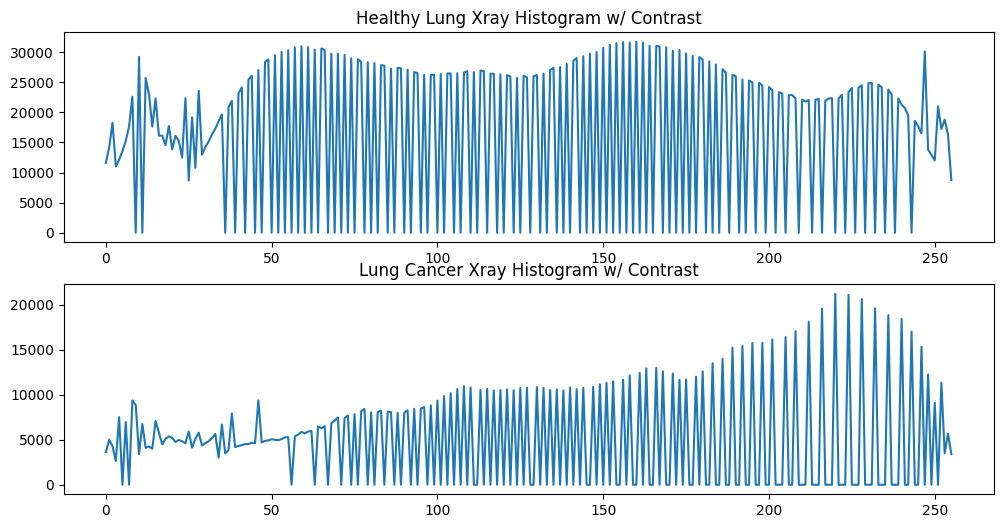

In [7]:
#Como será que são o histograma das imagens equalizadas?

hist_healthy_eq = cv2.calcHist([equalized_healthy],
                               [0], #Canais de cores
                               None, #Máscara
                               [256], #Tamanho do Histograma 
                               [0,256]) #Intervalo de tons de cinza desejado 
hist_cancer_eq = cv2.calcHist([equalized_cancer],
                               [0],
                               None,
                               [256],
                               [0,256])


fig, axes = plt.subplots(2, 1, figsize = (12,6))

axes[0].plot(hist_healthy_eq)
axes[0].set_title('Healthy Lung Xray Histogram w/ Contrast')

axes[1].plot(hist_cancer_eq)
axes[1].set_title('Lung Cancer Xray Histogram w/ Contrast')

plt.show()

## *Tentando* evidenciar as diferenças entre as imagens 

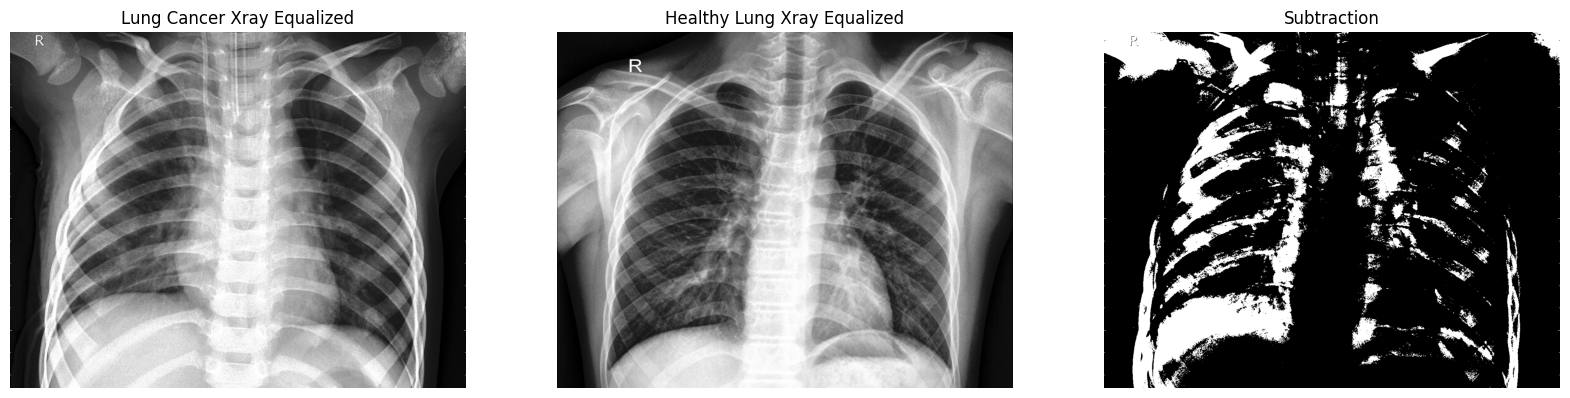

In [14]:
#Garantindo que ambas as imagens tenham o mesmo tamanho 


equalized_healthy = cv2.resize(
    equalized_healthy,
    (equalized_cancer.shape[1], equalized_cancer.shape[0])
)

diff = cv2.subtract(equalized_cancer, equalized_healthy)

_, diff_binarized = cv2.threshold(
    diff, 
    0,
    255, 
    cv2.THRESH_OTSU + cv2.THRESH_BINARY
)

#Visualizando o resultado 

fig, axes = plt.subplots(1,3, figsize = (20,12))

axes[0].imshow(equalized_cancer, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title('Lung Cancer Xray Equalized')

axes[1].imshow(equalized_healthy, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title('Healthy Lung Xray Equalized')

axes[2].imshow(diff_binarized, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title('Subtraction')

plt.show()


## Clusterização

In [15]:
#HK_D24

def HK_D24(img):
    n_linhas, n_colunas = img.shape #pegando o tamanho da imagem
    rotulos = np.zeros((n_linhas, n_colunas), dtype=int) #criando vetor de zeros p/ atribuir os rotulos
    prox_rot = 1
    igualdade = {}

    D24 = []

    
    for i in range(-2, 3):
        for j in range(-2, 3):
            if i == 0 and j == 0:
                continue  
            D24.append([i, j])


    for i in range(n_linhas): #construindo nosso loop para varrer a imagem e estabelecer a rotulagem
        for j in range(n_colunas):
            if img[i, j] == 1:
                vizinhos = []
                for alinhamento in D24:
                    ni, nj = i + alinhamento[0], j + alinhamento[1]
                    if 0 <= ni < n_linhas and 0 <= nj < n_colunas and rotulos[ni, nj] > 0:
                        vizinhos.append(rotulos[ni, nj])

                if not vizinhos:
                    rotulos[i, j] = prox_rot
                    prox_rot += 1
                else:
                    menor_rotulo = min(vizinhos)
                    rotulos[i, j] = menor_rotulo

                    for vizinho in vizinhos:
                        if vizinho != menor_rotulo:
                            if menor_rotulo not in igualdade:
                                igualdade[menor_rotulo] = set()
                            if vizinho not in igualdade:
                                igualdade[vizinho] = set()
                            igualdade[menor_rotulo].add(vizinho)
                            igualdade[vizinho].add(menor_rotulo)

    #equivalências de clusters
    for rotulo, eq_set in igualdade.items():
        min_eq_rotulo = min(eq_set)
        for eq_rotulo in eq_set:
            rotulos[rotulos == eq_rotulo] = min_eq_rotulo

    return rotulos

In [16]:
print(np.unique(diff_binarized))

[  0 255]


In [17]:
diff_binarized[diff_binarized == 255] = 1
diff_binarized[diff_binarized == 0] = 0

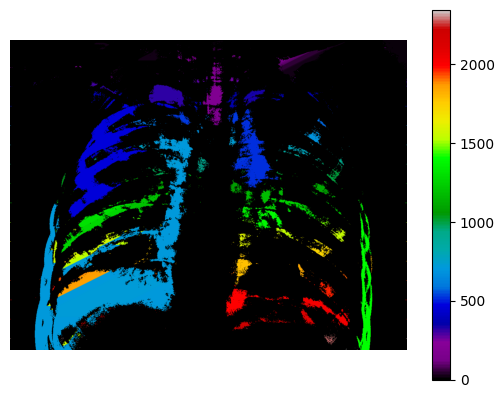

In [18]:
cluster_img = HK_D24(diff_binarized)

plt.imshow(cluster_img, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

# Adicionando ruído nas imagens 

### Existem diferentes perfís de ruídos que podem aparecer nas imagens, seja por causa dos meios de captura das imagens, conversão analógica/digital e outros demais fenômenos. 

Nessa seção, queremos entender um pouco sobre a influência de um ruído em uma imagem, além dos meios de suavização/filtragem desse ruído $\varepsilon$. 

In [ ]:
#Adicionando diferentes ruídos nas imagens para avaliar a distinção de impacto nas imagens 

#ruído gaussiano 
def gauss_noise(mu, sigma, shape): 
    noise = np.random.normal(mu, sigma, shape)
    return noise 

#ruído sal e pimenta
def salt_pepper(img, prob):

    noise = img.copy() 

    random_matrix = np.random.rand(*img.shape[:2])

    noise[random_matrix < (prob/2)] = 255 #salt

    noise[random_matrix > 1 - (prob/2)] = 0 #pepper 
    
    return noise 

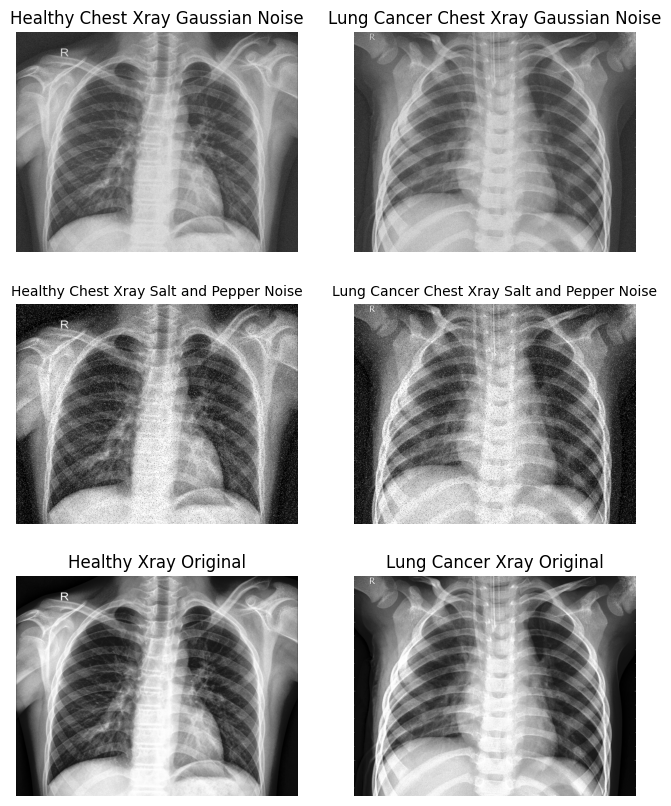

In [61]:
#Setando variáveis 

mu = 5
sigma = 15
prob = 0.1

#Aplicando o ruído nas imagens e visualizando 

eq_healthy_gauss = gauss_noise(mu, sigma, equalized_healthy.shape)
eq_cancer_gauss = gauss_noise(mu, sigma, equalized_cancer.shape)

eq_healthy_gaussnoise = equalized_healthy + eq_healthy_gauss
eq_cancer_gaussnoise = equalized_cancer + eq_cancer_gauss

eq_healthy_sp = salt_pepper(equalized_healthy, prob)
eq_cancer_sp = salt_pepper(equalized_cancer, prob)

#Visualizando as transformações 

fig, axes = plt.subplots(3, 2, figsize=(8,10))

axes[0,0].imshow(eq_healthy_gaussnoise, cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title('Healthy Chest Xray Gaussian Noise')

axes[0,1].imshow(eq_cancer_gaussnoise, cmap='gray')
axes[0,1].axis('off')
axes[0,1].set_title('Lung Cancer Chest Xray Gaussian Noise')

axes[1,0].imshow(eq_healthy_sp, cmap = 'gray')
axes[1,0].axis('off')
axes[1,0].set_title('Healthy Chest Xray Salt and Pepper Noise', fontsize=10)

axes[1,1].imshow(eq_cancer_sp, cmap = 'gray')
axes[1,1].axis('off')
axes[1,1].set_title('Lung Cancer Chest Xray Salt and Pepper Noise', fontsize=10)

axes[2,0].imshow(equalized_healthy, cmap = 'gray')
axes[2,0].axis('off')
axes[2,0].set_title('Healthy Xray Original')

axes[2,1].imshow(equalized_cancer, cmap = 'gray')
axes[2,1].axis('off')
axes[2,1].set_title('Lung Cancer Xray Original')

plt.show()

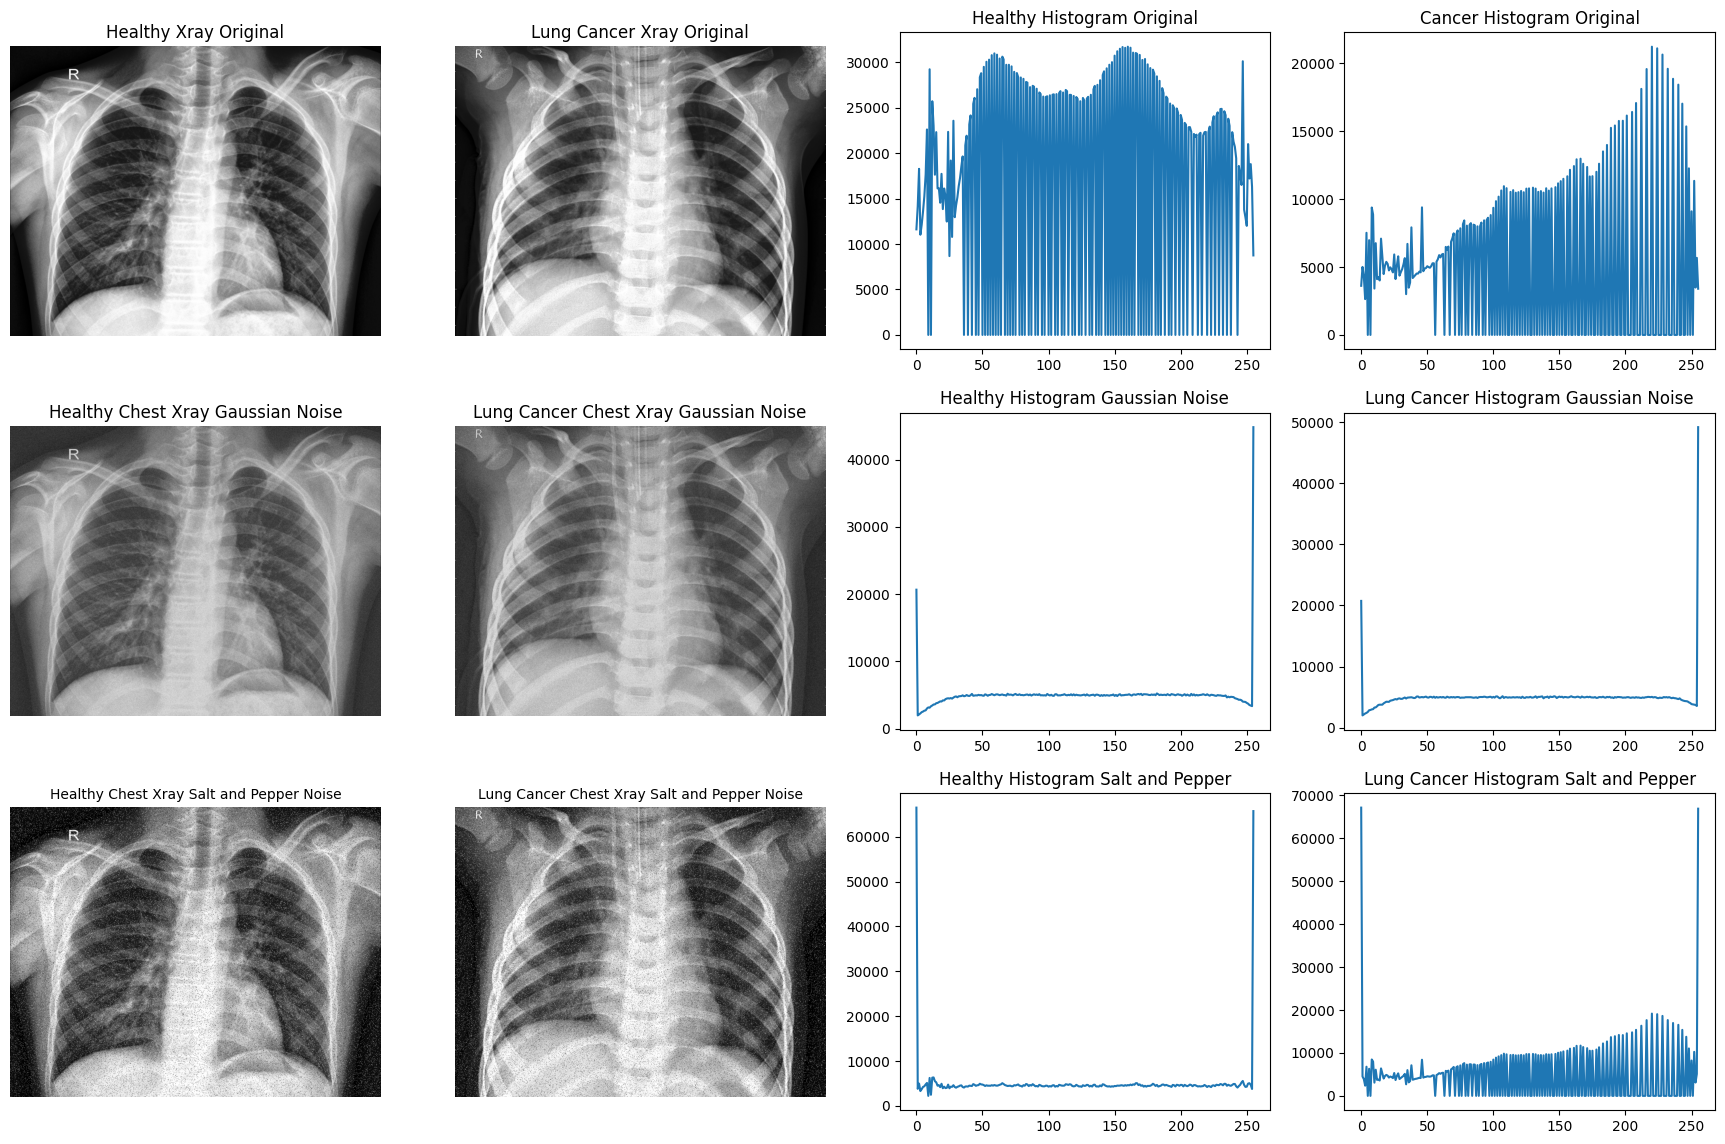

In [ ]:
eq_healthy_gaussnoise = np.clip(eq_healthy_gaussnoise, 0, 255).astype(np.uint8)
eq_cancer_gaussnoise  = np.clip(eq_cancer_gaussnoise,  0, 255).astype(np.uint8)
eq_healthy_sp         = np.clip(eq_healthy_sp,         0, 255).astype(np.uint8)
eq_cancer_sp          = np.clip(eq_cancer_sp,          0, 255).astype(np.uint8)

#Calculando e plotando os histogramas para avaliar o impacto do ruído nas imagens 

histgaussnoise_healthy = cv2.calcHist([eq_healthy_gaussnoise],
                                      [0], 
                                      None, 
                                      [256], 
                                      [0,256]) 
histgaussnoise_cancer = cv2.calcHist([eq_cancer_gaussnoise],
                                      [0], 
                                      None, 
                                      [256], 
                                      [0,256]) 

histsp_healthy = cv2.calcHist([eq_healthy_sp],
                                      [0], 
                                      None, 
                                      [256], 
                                      [0,256]) 
histsp_cancer = cv2.calcHist([eq_cancer_sp],
                                      [0], 
                                      None, 
                                      [256], 
                                      [0,256]) 


eq_healthy_gauss = gauss_noise(mu, sigma, equalized_healthy.shape)
eq_cancer_gauss = gauss_noise(mu, sigma, equalized_cancer.shape)

eq_healthy_gaussnoise = equalized_healthy + eq_healthy_gauss
eq_cancer_gaussnoise = equalized_cancer + eq_cancer_gauss

#Plotando e comparando os histogramas 

fig, axes = plt.subplots(3, 4, figsize = (22,14))

axes[0,2].plot(hist_healthy_eq)
axes[0,2].set_title('Healthy Histogram Original')

axes[0,3].plot(hist_cancer_eq)
axes[0,3].set_title('Cancer Histogram Original')

axes[1,2].plot(histgaussnoise_healthy)
axes[1,2].set_title('Healthy Histogram Gaussian Noise')

axes[1,3].plot(histgaussnoise_cancer)
axes[1,3].set_title('Lung Cancer Histogram Gaussian Noise')

axes[2,2].plot(histsp_healthy)
axes[2,2].set_title('Healthy Histogram Salt and Pepper')

axes[2,3].plot(histsp_cancer)
axes[2,3].set_title('Lung Cancer Histogram Salt and Pepper')

axes[1,0].imshow(eq_healthy_gaussnoise, cmap='gray')
axes[1,0].axis('off')
axes[1,0].set_title('Healthy Chest Xray Gaussian Noise')

axes[1,1].imshow(eq_cancer_gaussnoise, cmap='gray')
axes[1,1].axis('off')
axes[1,1].set_title('Lung Cancer Chest Xray Gaussian Noise')

axes[2,0].imshow(eq_healthy_sp, cmap = 'gray')
axes[2,0].axis('off')
axes[2,0].set_title('Healthy Chest Xray Salt and Pepper Noise', fontsize=10)

axes[2,1].imshow(eq_cancer_sp, cmap = 'gray')
axes[2,1].axis('off')
axes[2,1].set_title('Lung Cancer Chest Xray Salt and Pepper Noise', fontsize=10)

axes[0,0].imshow(equalized_healthy, cmap = 'gray')
axes[0,0].axis('off')
axes[0,0].set_title('Healthy Xray Original')

axes[0,1].imshow(equalized_cancer, cmap = 'gray')
axes[0,1].axis('off')
axes[0,1].set_title('Lung Cancer Xray Original')

plt.show()